In [2]:
from pyspark.sql import SparkSession
import squarify  
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("RFM Analysis with K-Means").getOrCreate()
rfm_df = spark.read.csv("rfm_df.csv", header=True, inferSchema=True)
rfm_df.show(3)

+----+-------------+-------+---------+--------+---+---+---+-----------+---------+--------------+
| _c0|Member_number|Recency|Frequency|Monetary|  R|  F|  M|RFM_Segment|RFM_Score|     RFM_Level|
+----+-------------+-------+---------+--------+---+---+---+-----------+---------+--------------+
|1388|         2433|      3|        7|  375.31|  4|  4|  4|        444|       12|Best Customers|
|1159|         2193|     91|       11|  361.45|  3|  4|  4|        344|       11|  Big Spenders|
| 772|         1793|     26|       10|   345.1|  4|  4|  4|        444|       12|Best Customers|
+----+-------------+-------+---------+--------+---+---+---+-----------+---------+--------------+
only showing top 3 rows



In [4]:
from pyspark.sql.functions import col

# Chọn các cột Recency, Frequency, Monetary
df_now = rfm_df.select("Recency", "Frequency", "Monetary")
df_now.show(5)

+-------+---------+--------+
|Recency|Frequency|Monetary|
+-------+---------+--------+
|      3|        7|  375.31|
|     91|       11|  361.45|
|     26|       10|   345.1|
|      4|       10|  334.15|
|    142|        7|  312.46|
+-------+---------+--------+
only showing top 5 rows



In [5]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Chuyển đổi dữ liệu thành vector
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="features")
df_vector = assembler.transform(df_now)

# Chuẩn hóa dữ liệu
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Hiển thị dữ liệu đã chuẩn hóa
df_scaled.select("scaled_features").show(5, truncate=False)

+-----------------------------------------------------------+
|scaled_features                                            |
+-----------------------------------------------------------+
|[-1.1550139478878978,1.6782936788871492,5.215690391142734] |
|[-0.6047136497345154,3.80179891634624,4.966499852627205]   |
|[-1.0111854608705366,3.2709226069814674,4.67254131693248]  |
|[-1.1487605354088821,3.2709226069814674,4.4756700040360125]|
|[-0.2857896133047142,1.6782936788871492,4.08570299246301]  |
+-----------------------------------------------------------+
only showing top 5 rows



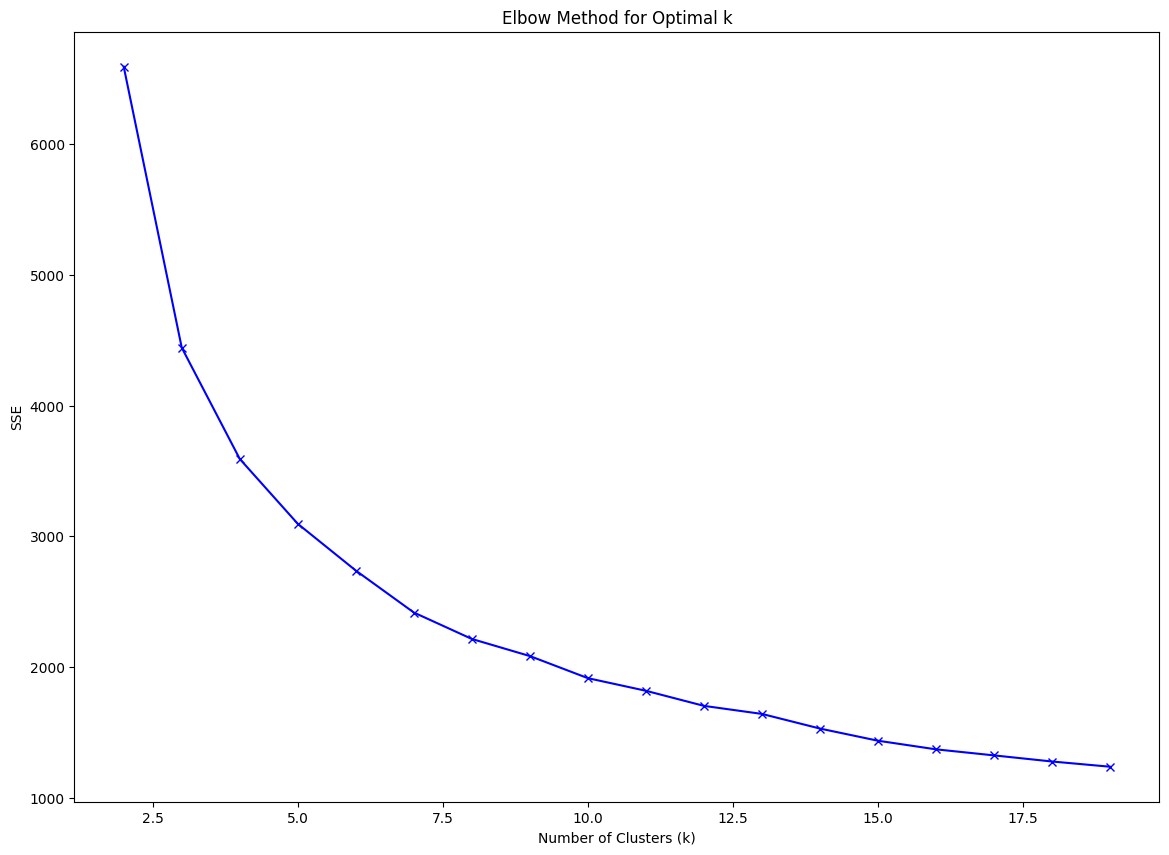

+-------+---------+--------+-------+
|Recency|Frequency|Monetary|Cluster|
+-------+---------+--------+-------+
|      3|        7|  375.31|      0|
|     91|       11|  361.45|      0|
|     26|       10|   345.1|      0|
|      4|       10|  334.15|      0|
|    142|        7|  312.46|      0|
+-------+---------+--------+-------+
only showing top 5 rows



In [13]:
from pyspark.ml.clustering import KMeans

# Tính SSE cho Elbow Method
sse = {}
for k in range(2, 20):  # Bắt đầu từ 2 vì k=1 không hợp lệ trong PySpark
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    sse[k] = model.summary.trainingCost

# Vẽ biểu đồ Elbow
import matplotlib.pyplot as plt
k_values = list(sse.keys())
sse_values = list(sse.values())
plt.figure(figsize=(14, 10))
plt.plot(k_values, sse_values, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()

# Phân cụm với k=4 (giả sử từ Elbow)
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=42)
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled).select("Recency", "Frequency", "Monetary", col("prediction").alias("Cluster"))
df_clustered.show(5)

In [14]:
# Tổng hợp dữ liệu theo cụm
rfm_agg = df_clustered.groupBy("Cluster").agg({
    "Recency": "avg",
    "Frequency": "avg",
    "Monetary": "avg",
    "Cluster": "count"
}).withColumnRenamed("count(Cluster)", "Count")
rfm_agg.show()

+-------+------------------+------------------+-----------------+-----+
|Cluster|      avg(Recency)|     avg(Monetary)|   avg(Frequency)|Count|
+-------+------------------+------------------+-----------------+-----+
|      1|430.36964078794904|  43.5919814600232|2.267670915411356|  863|
|      3|128.85692541856926|103.50401065449012|4.675038051750381| 1314|
|      2|  122.528706083976|49.517643530419804|2.634961439588689| 1167|
|      0| 86.53790613718411| 181.8562996389893|6.837545126353791|  554|
+-------+------------------+------------------+-----------------+-----+



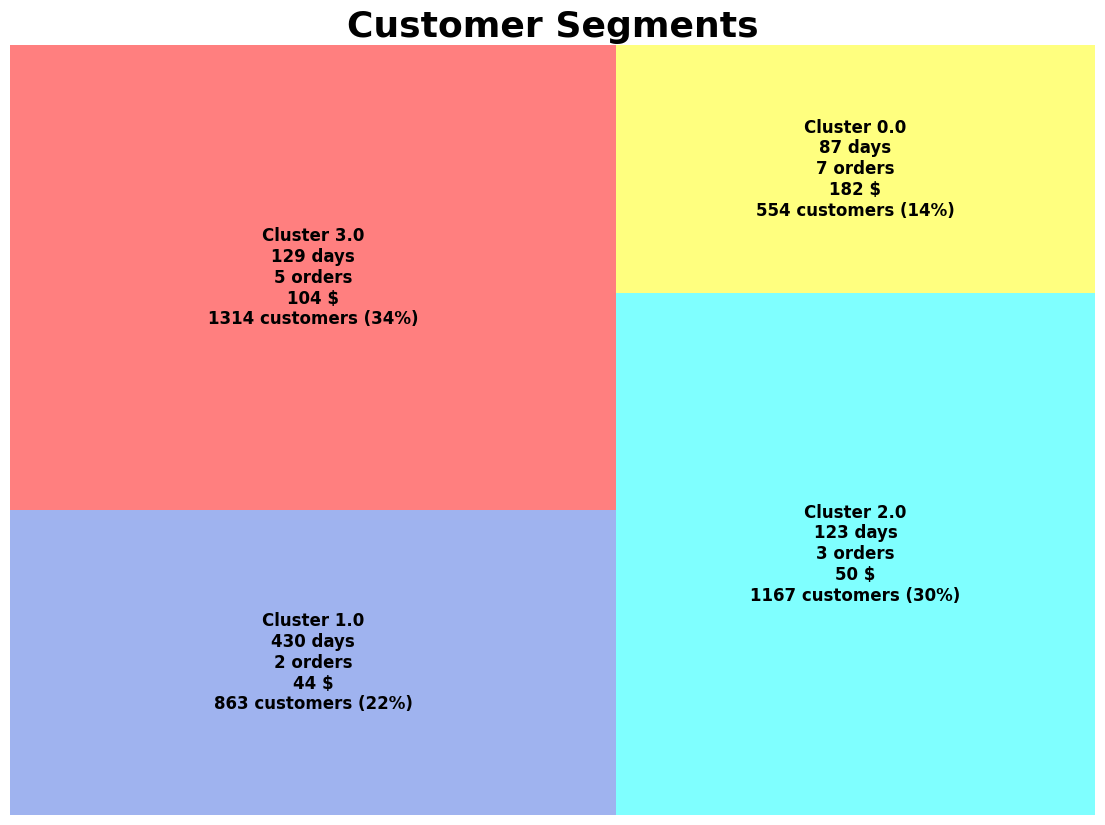

In [15]:
# Chuyển sang pandas DataFrame và vẽ treemap
rfm_agg_pd = rfm_agg.toPandas()
colors_dict = {0: "yellow", 1: "royalblue", 2: "cyan", 3: "red"}
plt.figure(figsize=(14, 10))
squarify.plot(
    sizes=rfm_agg_pd["Count"],
    color=[colors_dict[i] for i in rfm_agg_pd["Cluster"]],
    label=[
        f"Cluster {row['Cluster']}\n{row['avg(Recency)']:.0f} days\n{row['avg(Frequency)']:.0f} orders\n{row['avg(Monetary)']:.0f} $\n{row['Count']:.0f} customers ({row['Count']/rfm_agg_pd['Count'].sum()*100:.0f}%)"
        for _, row in rfm_agg_pd.iterrows()
    ],
    alpha=0.5,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"}
)
plt.title("Customer Segments", fontsize=26, fontweight="bold")
plt.axis("off")
plt.show()